## Ridge Regression Analysis of Baseline C-Peptide AUC Levels

This notebook performs ridge regression to predict log-transformed baseline 4-hour C-peptide AUC from the 3×3 model features. We will:
- Load and process the tidy baseline AUC datasets from SDY569, SDY797, and SDY1737.
- Train and evaluate local, federated, and retrained models using ridge regression.
- Use median MSE and interquartile range (IQR) to compare performance.
- Visualize predicted vs. actual outcomes.

Each dataset will be split into train/test partitions.


In [1]:
import os

# ========== STEP 0: Set working directory (for running locally on laptop) =========
os.getcwd()
os.chdir("/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody")
os.getcwd()

'/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody'

In [2]:
# Setup

import os
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model

# Set random seed for reproducibility
np.random.seed(42)


In [3]:
# === Feature Data Paths (raw tidy files) ===
feature_paths = {
    "SDY569": "data/SDY569_tidy.csv",
    "SDY797": "data/SDY797_tidy.csv",
    "SDY1737": "data/SDY1737_tidy.csv"
}

# === Ground Truth C-Peptide Labels ===
cpeptide_paths = {
    "SDY569": "data/SDY569_cpeptide_auc_tidy.csv",
    "SDY797": "data/SDY797_cpeptide_auc_tidy.csv",
    "SDY1737": "data/SDY1737_cpeptide_auc_tidy.csv"
}

# === CNN Output Features (Used for Ridge Regression) ===
# These were saved from the trained CNNs, so they include "Accession" for alignment
cnn_test_feature_paths = {
    "SDY569": "test_data/SDY569_3x3_test.csv",
    "SDY797": "test_data/SDY797_3x3_test.csv",
    "SDY1737": "test_data/SDY1737_3x3_test.csv"
}

# === Local CNN Model Paths ===
local_model_paths = {
    "SDY569": "models/SDY569_3x3_model.keras",
    "SDY797": "models/SDY797_3x3_model.keras",
    "SDY1737": "models/SDY1737_3x3_model.keras",  # ← FIXED typo (was SD1737)
}

# === Federated CNN Model Path ===
federated_model_path = {
    "federated": "models/federated_3x3_model.keras",
}

# === Retrained CNN Model Paths (fine-tuned per-study) ===
retrained_model_paths = {
    "SDY569": "models/SDY569_RETRAINED_3x3_model.keras",
    "SDY797": "models/SDY797_RETRAINED_3x3_model.keras",
    "SDY1737": "models/SDY1737_RETRAINED_3x3_model.keras",  # ← FIXED typo (was SD1737)
}


In [4]:
import pandas as pd

# Load all feature, label, and CNN test data
feature_dfs   = {study: pd.read_csv(path) for study, path in feature_paths.items()}
cpeptide_dfs  = {study: pd.read_csv(path) for study, path in cpeptide_paths.items()}
cnn_test_dfs  = {study: pd.read_csv(path) for study, path in cnn_test_feature_paths.items()}

# Merge feature + label data on Subject_ID
merged_dfs = {}

for study in feature_dfs:
    print(f"\nMerging data for {study}")

    df_feat = feature_dfs[study].copy()
    df_cpep = cpeptide_dfs[study].copy()

    # Rename "Accession" → "Subject_ID" if needed
    if "Accession" in df_feat.columns:
        df_feat = df_feat.rename(columns={"Accession": "Subject_ID"})

    if "Subject_ID" not in df_feat.columns or "Subject_ID" not in df_cpep.columns:
        raise ValueError(f"Missing 'Subject_ID' in {study}")

    merged = pd.merge(df_feat, df_cpep, on="Subject_ID", how="inner")
    merged_dfs[study] = merged

    print(f"  Feature shape:  {df_feat.shape}")
    print(f"  C-peptide shape:{df_cpep.shape}")
    print(f"  Merged shape:   {merged.shape}")
    print("  Sample rows from merged data:")
    print(merged.head(3))



Merging data for SDY569
  Feature shape:  (30, 6)
  C-peptide shape:(10, 6)
  Merged shape:   (30, 11)
  Sample rows from merged data:
  Subject_ID     Sex Age_Group Property  Value Study_x Study_y  \
0  SUB151307  Female      8-12    gad65   0.04  SDY569  SDY569   
1  SUB151307  Female      8-12   ia_2ic   0.71  SDY569  SDY569   
2  SUB151307  Female      8-12     miaa   2.08  SDY569  SDY569   

    Participant_ID Visit_Label  C_Peptide_AUC_4Hrs  Units  
0  ITN007AI_195962    Baseline              0.5625  NG/ML  
1  ITN007AI_195962    Baseline              0.5625  NG/ML  
2  ITN007AI_195962    Baseline              0.5625  NG/ML  

Merging data for SDY797
  Feature shape:  (245, 6)
  C-peptide shape:(49, 6)
  Merged shape:   (245, 11)
  Sample rows from merged data:
  Subject_ID   Sex Age_Group Property  Value Study_x Study_y Participant_ID  \
0  SUB168890  Male      8-12    GAD65    1.0  SDY797  SDY797   T1DAL_137962   
1  SUB168890  Male      8-12   IA_2ic    0.0  SDY797  SDY797   

In [5]:
cnn_features = ["GAD65", "IA2IC", "MIAA", "ICA", "ZNT8", "8-12", "13-17", "18-30", "Sex"]


In [6]:
# Initialize a container to hold data for Ridge regression training and testing
ridge_inputs = {
    "local": {},
    "federated": {},
    "retrained": {}
}


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

def run_ridge_pipeline(
    study,
    model_type,  # "local", "federated", or "retrained"
    merged_dfs,
    test_dfs,
    model_paths,
    cnn_features=["GAD65", "IA2IC", "MIAA", "ICA", "ZNT8", "8-12", "13-17", "18-30", "Sex"],
    alpha=0.0001,
    plot=True
):
    print(f"\n--- Ridge Regression for {study.upper()} ({model_type}) ---")

    # === Load CNN Model ===
    if model_type == "federated":
        model = load_model(model_paths["federated"])
        test_df = test_dfs[study]
    else:
        model = load_model(model_paths[study])
        test_df = test_dfs[study]

    if "Accession" not in test_df.columns:
        raise ValueError("Expected 'Accession' column in test data")
    subject_ids = test_df["Accession"]

    # === Prepare test features for CNN ===
    X_input = test_df[cnn_features].values.astype("float32").reshape(-1, 3, 3, 1)

    # === Get encoded features ===
    cnn_output = model.predict(X_input).reshape(len(X_input), -1)
    print("CNN output sample:")
    print(cnn_output[:5])

    # === Get matching labels ===
    merged = merged_dfs[study]
    merged = merged.rename(columns={"Accession": "Subject_ID"})  # Ensure consistent name
    merged = merged.set_index("Subject_ID")
    
    # Filter to match only the subject IDs present in test_df
    merged_subset = merged.loc[subject_ids]
    merged_subset = merged_subset.loc[~merged_subset.index.duplicated(keep="first")]
    y = np.log1p(merged_subset["C_Peptide_AUC_4Hrs"].values)

    if len(y) != len(cnn_output):
        print(f"[{study}] SHAPE MISMATCH: y {y.shape}, cnn_output {cnn_output.shape}")
        return

    # === Train/test split ===
    X_train, X_test, y_train, y_test = train_test_split(cnn_output, y, test_size=0.5, random_state=42)

    # === Fit Ridge Regression ===
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)

    # === Evaluation ===
    mse = mean_squared_error(y_test, y_pred)
    formula = f"y = {ridge.intercept_:.2f} + " + " + ".join([f"{coef:.2f}x{i}" for i, coef in enumerate(ridge.coef_)])
    print(f"  Ridge MSE: {mse:.4f}")
    print(f"  Regression formula:\n  {formula}")

    if plot:
        # === Plot ===
        plt.figure(figsize=(6, 5))
        plt.scatter(y_test, y_pred, alpha=0.8)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", label="Ideal")
        plt.xlabel("True log C-Peptide AUC")
        plt.ylabel("Predicted log C-Peptide AUC")
        plt.title(f"{study} - {model_type.capitalize()} Ridge Regression\nMSE: {mse:.4f}")
        plt.legend()
        plt.grid(True)
        plt.show()

    return {
        "study": study,
        "model_type": model_type,
        "ridge_model": ridge,
        "mse": mse,
        "y_test": y_test,
        "y_pred": y_pred,
        "formula": formula
    }



--- Ridge Regression for SDY569 (local) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
CNN output sample:
[[ 0.24453399  0.39096084  0.22308995  0.14704     0.16877954  0.3246262
  -0.10984445  0.18136914 -0.03275405]
 [ 0.14462076  0.2264337   0.16629323  0.02667538  0.1373288   0.19304481
   0.0474416   0.03202321  0.01351885]
 [ 0.16983016  0.30868343  0.20171872  0.04118788  0.20608857  0.23344322
   0.08209697  0.02199425  0.01174497]
 [ 0.3108534   0.4769499   0.27478164  0.18714973  0.2261617   0.39389652
  -0.15398358  0.23751251 -0.05354243]
 [ 0.10443239  0.15534766  0.13473965  0.01525269  0.12874563  0.16036893
   0.06929295  0.01654571  0.02204368]]
  Ridge MSE: 1.1963
  Regression formula:
  y = -1.03 + 0.68x0 + 0.88x1 + 0.53x2 + 0.41x3 + 0.58x4 + 0.71x5 + -0.45x6 + 0.57x7 + -0.21x8


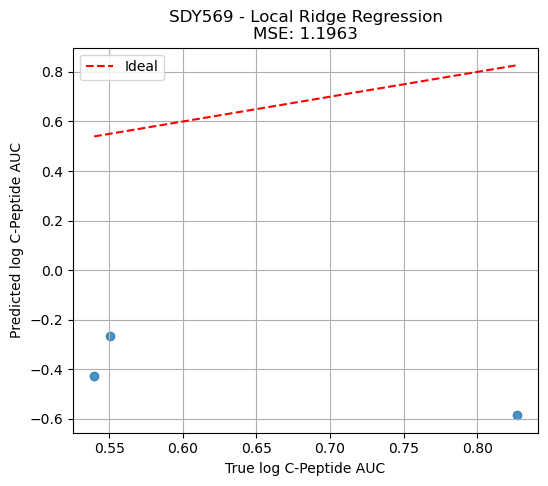


--- Ridge Regression for SDY569 (retrained) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
CNN output sample:
[[0.18936273 0.3004398  0.12011852 0.2118164  0.08623508 0.49418902
  0.13658729 0.44374585 0.24293059]
 [0.16026479 0.2426832  0.11151265 0.16961837 0.08735076 0.37557375
  0.12157477 0.34369183 0.19473806]
 [0.18207979 0.29060802 0.13243988 0.19614127 0.11103417 0.42082128
  0.14167663 0.39069533 0.21730876]
 [0.20507208 0.3146285  0.13218895 0.21102321 0.09447916 0.51402426
  0.14758031 0.46807924 0.2559183 ]
 [0.17274086 0.27334404 0.11177514 0.19557166 0.08232546 0.44380897
  0.12680505 0.39834806 0.22078606]]
  Ridge MSE: 1.2747
  Regression formula:
  y = -4.76 + 2.24x0 + 2.02x1 + 1.72x2 + -0.11x3 + 1.18x4 + 2.83x5 + 1.57x6 + 3.47x7 + 1.85x8


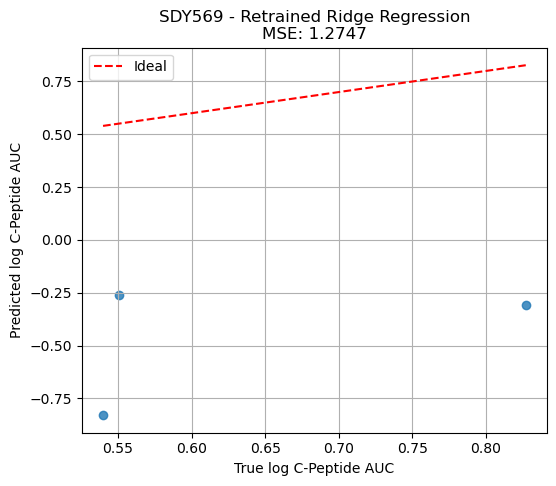


--- Ridge Regression for SDY569 (federated) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
CNN output sample:
[[0.12963562 0.12716174 0.1185711  0.14107639 0.16268544 0.16645235
  0.09608467 0.10940428 0.11942189]
 [0.14374638 0.14407931 0.13005844 0.15752044 0.18246171 0.17419355
  0.06868498 0.12159304 0.10526191]
 [0.14441599 0.14369182 0.13083485 0.15786849 0.18413123 0.16978362
  0.06453265 0.12761894 0.10222293]
 [0.1439125  0.14414784 0.13044854 0.15931845 0.18281409 0.18133649
  0.07048854 0.11565354 0.10770478]
 [0.14300683 0.14145102 0.12475891 0.1597853  0.18275078 0.18139175
  0.07413922 0.11524055 0.11053193]]
  Ridge MSE: 0.0666
  Regression formula:
  y = -1.07 + 1.66x0 + 1.97x1 + 1.38x2 + 2.12x3 + 2.34x4 + 1.73x5 + -2.97x6 + 0.73x7 + -1.36x8


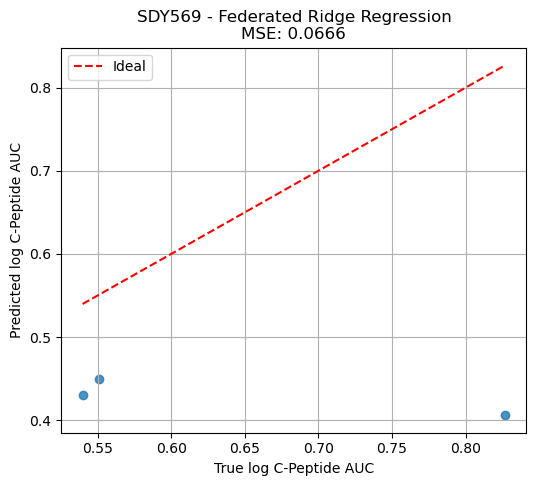


--- Ridge Regression for SDY797 (local) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
CNN output sample:
[[ 9.2810237e-01  6.5115356e-01  8.1938642e-01  4.3156102e-01
   9.9286693e-01  9.4916350e-01  1.9799173e-04  3.7419024e-01
   5.6176800e-01]
 [ 4.7078037e-01  4.0456736e-01  3.8483769e-01  1.8251762e-01
   3.4570932e-01  4.8007199e-01  1.2297475e-01  2.1273145e-01
   2.7518803e-01]
 [ 9.7213048e-01  6.8541497e-01  8.5034889e-01  4.4646308e-01
   1.0375010e+00  9.8503894e-01  1.8800721e-03  3.9730436e-01
   5.9066719e-01]
 [ 7.6347524e-01  6.2140119e-01  5.6010312e-01  2.6675221e-01
   6.1634320e-01  7.1876478e-01  1.4735281e-01  3.4365803e-01
   4.4044128e-01]
 [ 7.5662780e-01  5.1536554e-01  7.0763177e-01  3.7851036e-01
   8.3750504e-01  7.9504329e-01 -1.3369113e-02  3.0880165e-01
   4.7860879e-01]]
  Ridge MSE: 0.0331
  Regression formula:
  y = 0.33 + 5.14x0 + -3.37x1 + -7.94x2 + 0.09x3 + 3.80x4 + 5.53x5 + 2.52x6 + -4.58x7 + -5.43x8


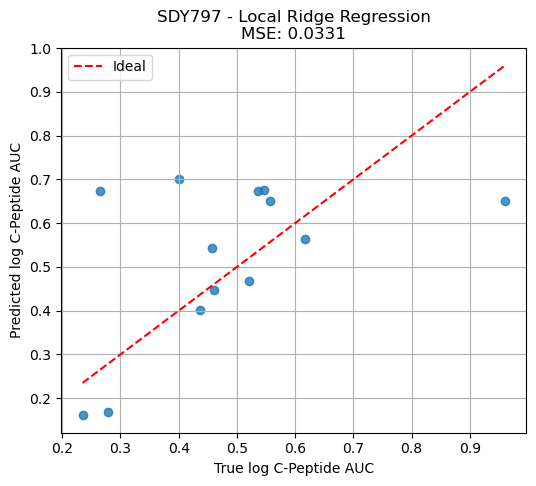


--- Ridge Regression for SDY797 (retrained) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
CNN output sample:
[[0.7832686  0.6650257  0.5718028  0.74067956 0.54288864 0.77153045
  0.39116758 0.512674   0.14695351]
 [0.69248736 0.5732917  0.45400524 0.69188094 0.36419266 0.7673586
  0.30319425 0.49101472 0.14706102]
 [0.8655731  0.73049647 0.6144947  0.8202993  0.5852022  0.8548634
  0.42270732 0.5625701  0.15496929]
 [0.8021916  0.6784773  0.5610843  0.78097254 0.50106645 0.8563766
  0.3800457  0.55486405 0.15685287]
 [0.8127399  0.6683096  0.5321878  0.7860332  0.47298157 0.8256692
  0.36550277 0.53376377 0.15101585]]
  Ridge MSE: 0.0441
  Regression formula:
  y = 1.39 + -0.15x0 + 0.87x1 + 1.86x2 + 0.27x3 + 1.02x4 + -2.91x5 + 0.44x6 + -1.39x7 + -0.47x8


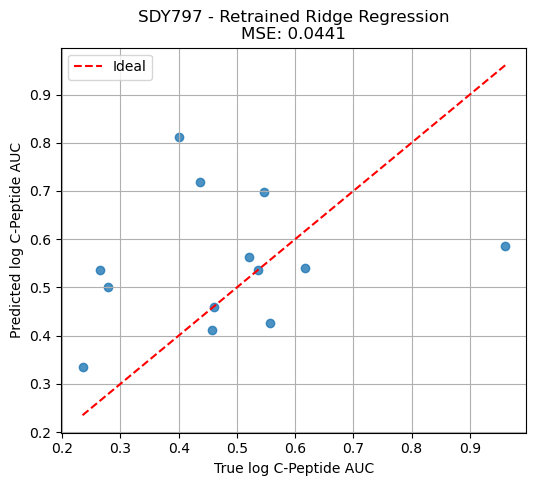


--- Ridge Regression for SDY797 (federated) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
CNN output sample:
[[0.16851895 0.154939   0.14913478 0.20138022 0.22083142 0.19916096
  0.03817626 0.12317736 0.09112684]
 [0.16094926 0.16166823 0.14751258 0.15755546 0.21065128 0.18296295
  0.03652196 0.13021629 0.09073366]
 [0.16918294 0.15119494 0.1448999  0.20124023 0.22762147 0.19920188
  0.03598932 0.12746787 0.09112482]
 [0.15161082 0.15365675 0.13967335 0.15416405 0.19825585 0.17481826
  0.05045904 0.1294807  0.09608583]
 [0.16136771 0.16305329 0.14306378 0.15819821 0.20904885 0.1828895
  0.03949743 0.12961929 0.0924658 ]]
  Ridge MSE: 0.0410
  Regression formula:
  y = -0.18 + -1.72x0 + -4.96x1 + -3.93x2 + 2.06x3 + 2.78x4 + 7.12x5 + 1.64x6 + -2.27x7 + 3.21x8


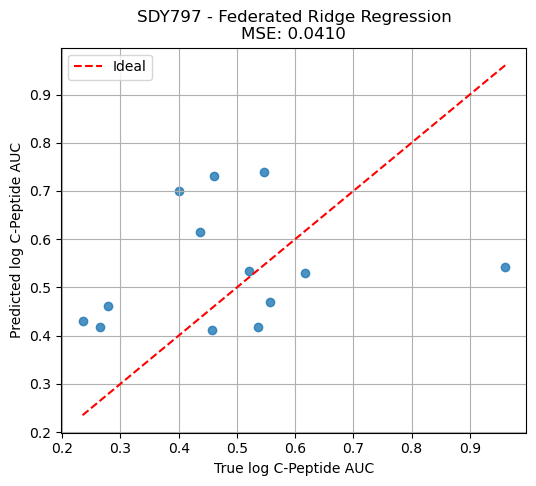


--- Ridge Regression for SDY1737 (local) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
CNN output sample:
[[ 0.00139152  0.16129746  0.0114895   0.10535797  0.0239607   0.09181422
   0.06505955  0.05812811  0.12219955]
 [ 0.05318236  0.05111003  0.06994127  0.04524596  0.06737673  0.08056502
   0.05736665  0.04701725  0.07418604]
 [-0.01144129  0.18835256 -0.00039087  0.11982425  0.0220035   0.09908941
   0.06717676  0.06318927  0.13785662]
 [ 0.00804134  0.1563665   0.02171951  0.09631179  0.02981848  0.10049875
   0.06087263  0.06017868  0.12830983]
 [ 0.06503685  0.08794555  0.10826284  0.08781867  0.14001907  0.09719045
   0.01116516  0.11260031  0.07684745]]
  Ridge MSE: 0.1291
  Regression formula:
  y = 1.57 + -1.59x0 + -4.94x1 + 1.83x2 + -3.38x3 + -5.65x4 + 3.48x5 + 0.11x6 + -4.50x7 + 2.18x8


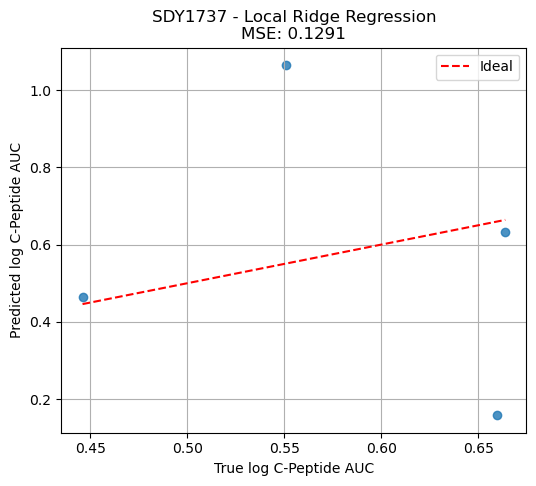


--- Ridge Regression for SDY1737 (retrained) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
CNN output sample:
[[0.24743742 0.2433376  0.19408646 0.15318939 0.33010468 0.25319856
  0.2009112  0.21423933 0.13109633]
 [0.2097241  0.26350024 0.16087434 0.1896944  0.2205154  0.3907759
  0.16303101 0.2870646  0.16343677]
 [0.21646848 0.20837829 0.18295601 0.12400342 0.30566472 0.19429627
  0.18568602 0.17600712 0.11632857]
 [0.26491052 0.34182066 0.19191703 0.24251306 0.28140152 0.5331767
  0.20333996 0.38154897 0.20167336]
 [0.30321997 0.29473224 0.24541265 0.17934063 0.45503038 0.3087525
  0.2554016  0.2713748  0.17322925]]
  Ridge MSE: 0.0574
  Regression formula:
  y = 1.44 + -1.74x0 + -0.32x1 + -0.39x2 + -1.31x3 + -1.58x4 + 1.14x5 + -0.23x6 + 0.37x7 + -0.29x8


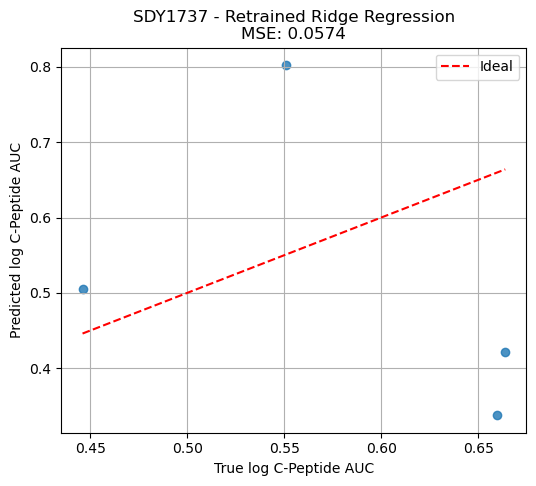


--- Ridge Regression for SDY1737 (federated) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
CNN output sample:
[[0.12710498 0.12519692 0.1185711  0.13915819 0.16076402 0.16432409
  0.09787633 0.11007906 0.11960905]
 [0.13773729 0.13671163 0.12398162 0.15417731 0.17718056 0.18403158
  0.08312541 0.10709871 0.11578964]
 [0.1208643  0.11815096 0.11955132 0.14049578 0.16207719 0.16291757
  0.09599705 0.11657271 0.11744659]
 [0.1233459  0.12227832 0.1185711  0.13863279 0.15821683 0.15826437
  0.09812582 0.11584059 0.11758611]
 [0.14263618 0.140899   0.12919386 0.15718071 0.1838462  0.16861966
  0.06574941 0.1287846  0.10285701]]
  Ridge MSE: 0.0641
  Regression formula:
  y = 2.74 + -2.34x0 + -1.71x1 + -2.62x2 + -1.86x3 + -5.61x4 + -5.42x5 + 4.82x6 + 0.87x7 + 1.11x8


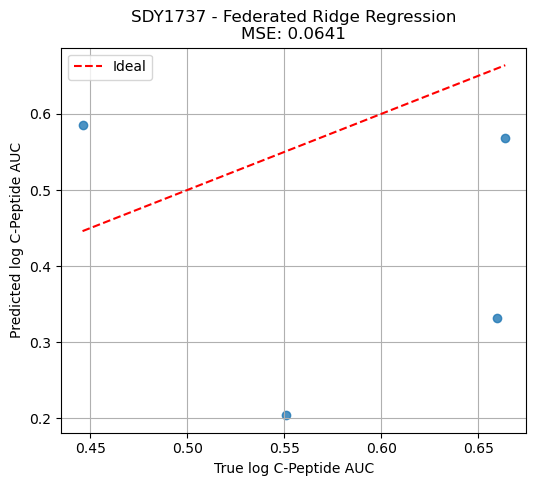

In [8]:
ridge_results = {}

for study in ["SDY569", "SDY797", "SDY1737"]:
    for model_type, paths in zip(
        ["local", "retrained", "federated"],
        [local_model_paths, retrained_model_paths, federated_model_path]
    ):
        ridge_results[(study, model_type)] = run_ridge_pipeline(
            study=study,
            model_type=model_type,
            merged_dfs=merged_dfs,
            test_dfs=cnn_test_dfs,
            model_paths=paths,
            plot=True
        )
        

